In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *
# from aodfunctions.outofplane import *

cupyon=True

try: 
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    from numpy.lib.stride_tricks import as_strided
    print("cupy not installed. Using numpy.")

import diffractsim
diffractsim.set_backend("CPU") #Change the string to "CUDA" to use GPU acceleration

from diffractsim import MonochromaticField, Lens, nm, mm, cm, RectangularSlit


cupy not installed. Using numpy.
Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077
cupy not installed. Using numpy.


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 205*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -20*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 20*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 10000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")
print(len(AWGwaveform))

Tweezer starting positions: -20.0 microns or -2.267573696145124 MHz
Tweezer ending positions: 20.0 microns or 2.267573696145124 MHz
One micron corresponds to 0.1133786848072586 MHz
9883


In [4]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp_general(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)

expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
expanded_acceleration, expanded_time = expand_position_array(time, optimized_acceleration, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)
# init_forces = retrieveforces(AWGinitguessexponential, globalvariables, 10, True)
# init_potentials = retrievepotentials(AWGinitguessexponential, globalvariables, 10, True)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

c:\cleen\Apps\Python3.11\Lib\site-packages\numpy\polynomial\legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


Maximum error: 2.692328280318179e-07


In [79]:
def interpolate_potential_cp(potential_slices, xspacing, zspacing):
    """
    Interpolate a 2D potential profile from slices using CuPy.

    Parameters:
    potential_slices (cupy.ndarray): Array of 1D arrays, each representing a slice of the potential along the x-axis.
    xspacing (float): Spatial spacing of each pixel in each frame.
    zspacing (float): Spatial spacing in the z-direction between each frame.

    Returns:
    cupy.ndarray: Interpolated 2D potential profile.
    """
    potential_slices = cp.asarray(potential_slices)
    num_slices, num_points = potential_slices.shape
    z_coords = cp.arange(num_slices) * zspacing
    x_coords = cp.arange(num_points) * xspacing

    zz, xx = cp.meshgrid(z_coords, x_coords, indexing='ij')
    return potential_slices, zz, xx

def compute_gradient_cp(potential_2d, xspacing, zspacing):
    """
    Compute the gradient of a 2D potential profile using CuPy with second-order central differences.

    Parameters:
    potential_2d (cupy.ndarray): 2D potential profile with shape (numframes, lenframe).
    xspacing (float): Spatial spacing of each pixel in each frame.
    zspacing (float): Spatial spacing in the z-direction between each frame.

    Returns:
    tuple: Gradients in the x and z directions.
    """
    numframes, lenframe = potential_2d.shape
    
    # Initialize gradients
    grad_x = cp.zeros_like(potential_2d)
    grad_z = cp.zeros_like(potential_2d)
    
    # Compute second-order central differences for interior points
    grad_x[:, 2:-2] = (-potential_2d[:, 4:] + 8 * potential_2d[:, 3:-1] - 8 * potential_2d[:, 1:-3] + potential_2d[:, :-4]) / (12 * xspacing)
    grad_z[2:-2, :] = (-potential_2d[4:, :] + 8 * potential_2d[3:-1, :] - 8 * potential_2d[1:-3, :] + potential_2d[:-4, :]) / (12 * zspacing)
    
    # Handle boundaries with first-order differences
    grad_x[:, 0] = (potential_2d[:, 1] - potential_2d[:, 0]) / xspacing
    grad_x[:, 1] = (potential_2d[:, 2] - potential_2d[:, 0]) / (2 * xspacing)
    grad_x[:, -2] = (potential_2d[:, -1] - potential_2d[:, -3]) / (2 * xspacing)
    grad_x[:, -1] = (potential_2d[:, -1] - potential_2d[:, -2]) / xspacing
    
    grad_z[0, :] = (potential_2d[1, :] - potential_2d[0, :]) / zspacing
    grad_z[1, :] = (potential_2d[2, :] - potential_2d[0, :]) / (2 * zspacing)
    grad_z[-2, :] = (potential_2d[-1, :] - potential_2d[-3, :]) / (2 * zspacing)
    grad_z[-1, :] = (potential_2d[-1, :] - potential_2d[-2, :]) / zspacing
    
    return grad_x, grad_z

def interpolate_gradient_cp(grad_x, grad_z, x_coords, y_coords):
    """
    Interpolates the gradient at specific coordinates using bilinear interpolation with CuPy.

    Parameters:
    grad_x (cupy.ndarray): Gradient in the x direction.
    grad_z (cupy.ndarray): Gradient in the z direction.
    x_coords (list or array): x coordinates to retrieve the gradient at.
    y_coords (list or array): y coordinates to retrieve the gradient at.
    xspacing (float): Spatial spacing of each pixel in each frame.
    zspacing (float): Spatial spacing in the z-direction between each frame.

    Returns:
    tuple: Interpolated gradients at the specified coordinates.
    """
    # Convert coordinates to grid space
    x_coords = cp.array(x_coords) 
    y_coords = cp.array(y_coords) 

    x0 = cp.floor(x_coords).astype(cp.int32)
    x1 = x0 + 1
    y0 = cp.floor(y_coords).astype(cp.int32)
    y1 = y0 + 1

    x0 = cp.clip(x0, 0, grad_x.shape[1] - 1)
    x1 = cp.clip(x1, 0, grad_x.shape[1] - 1)
    y0 = cp.clip(y0, 0, grad_x.shape[0] - 1)
    y1 = cp.clip(y1, 0, grad_x.shape[0] - 1)

    Ia_x = grad_x[y0, x0]
    Ib_x = grad_x[y1, x0]
    Ic_x = grad_x[y0, x1]
    Id_x = grad_x[y1, x1]

    Ia_z = grad_z[y0, x0]
    Ib_z = grad_z[y1, x0]
    Ic_z = grad_z[y0, x1]
    Id_z = grad_z[y1, x1]

    wa = (x1 - x_coords) * (y1 - y_coords)
    wb = (x1 - x_coords) * (y_coords - y0)
    wc = (x_coords - x0) * (y1 - y_coords)
    wd = (x_coords - x0) * (y_coords - y0)

    interpolated_grad_x = wa * Ia_x + wb * Ib_x + wc * Ic_x + wd * Id_x
    interpolated_grad_z = wa * Ia_z + wb * Ib_z + wc * Ic_z + wd * Id_z

    return interpolated_grad_x, interpolated_grad_z

def snapshots_oop_potential(AWGframe_E, netpower, znumoffsets, zstart, zspacing, frameheight_real, framesizes, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    ''' Get znumoffsets snapshots of the fourier transform, starting at zstart and propagating through znumoffsets frames at zspacing. 
    Frameheight_real is the number of y-frames to use (pick an odd number to avoid interpolating), while framsizes determines the
    x and y padding beyond the start and end locations. Netpower is for power conservation, but only of ONE
    1D frame at the FOCAL point. So be sure to get only one slice from the bluestein propagation.'''
    xextent = framesizes[0]
    yextent = framesizes[1]

    AWGframe_E = array_1dto2d(AWGframe_E, frameheight_real)
    
    snapshotsout = cp.zeros((znumoffsets, numpix_frame))
    
    F = MonochromaticField(
        wavelength = wavelength, extent_x=numpix_frame * pixelsize_real, extent_y=numpix_frame * pixelsize_real, 
        Nx=numpix_frame, Ny=frameheight_real, intensity =1.
    )
    F.E = AWGframe_E
    F.propagate(focallength)
    F.add(Lens(focallength, radius = numpix_frame * pixelsize_real / 2))
    F.zoom_propagate(zstart,
             x_interval = [startlocation - xextent, endlocation+xextent], y_interval = [- yextent, +yextent])
    I = F.get_intensity()
    I = I / cp.sum(cp.abs(I)) * netpower
    Icut = I[(len(I)-1)//2]
    snapshotsout[0, :] = Icut.astype(cp.float32)
    
    for i in range(1,znumoffsets):
        F.propagate(zspacing)
        I = F.get_intensity()
        I = I / cp.sum(cp.abs(I)) * netpower
        Icut = I[(len(I)-1)//2]
        snapshotsout[i, :] = Icut.astype(cp.float)
        
    return snapshotsout

def retrieve_oop_potentials(AWGwaveform, znumoffsets, zstart, zspacing, frameheight_real, framesizes, globalvariables,
                            timeperframe = 1):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

    tweezerenergy_max = hbar * tweezerdepth
    calibrationshot = snapshots_oop_potential(AWGinitguessexponential[0:500], 1, 1, focallength, 0,
                                  frameheight_real, framesizes, globalvariables)
    calibrationshot_max = cp.max(calibrationshot)
    normalizedenergy = tweezerenergy_max / calibrationshot_max

    num_snapshots = (len(AWGwaveform) - numpix_frame) // timeperframe + 1
    
    # Create a view of the input array with overlapping windows
    strides = (AWGwaveform.strides[0] * timeperframe, AWGwaveform.strides[0])
    shape = (num_snapshots, numpix_frame)
    snapshots = as_strided(AWGwaveform, shape=shape, strides=strides)


    def wrapper(waveformshot):
        return snapshots_oop_potential(waveformshot, normalizedenergy, znumoffsets, zstart, zspacing,
                                       frameheight_real, framesizes, globalvariables)
    
    frames_2d = cp.array([wrapper(snap) for snap in snapshots])

    # snapshots = cp.array([realtofourier_norm(zeropadframe(snap, globalvariables),calibrationshot_energy) for snap in snapshots]).astype(float)
    if timeperframe > 1:
        interpolated_snapshots = cp.zeros((num_snapshots + (num_snapshots - 1) * (timeperframe - 1), znumoffsets,numpix_frame), dtype=cp.float)
        interpolated_snapshots[::timeperframe] = frames_2d
        
        for i in range(1, timeperframe):
            interpolated_snapshots[i::timeperframe] = (frames_2d[:-1] * (timeperframe - i) + frames_2d[1:] * i) / timeperframe

        return interpolated_snapshots

    return frames_2d

def retrieve_oop_forces(AWGwaveform, znumoffsets, zstart, zspacing, frameheight_real, framesizes, globalvariables,
                            timeperframe = 1):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

    tweezerenergy_max = hbar * tweezerdepth
    calibrationshot = snapshots_oop_potential(AWGinitguessexponential[0:500], 1, 1, focallength, 0,
                                  frameheight_real, framesizes, globalvariables)
    calibrationshot_max = cp.max(calibrationshot)
    normalizedenergy = tweezerenergy_max / calibrationshot_max

    num_snapshots = (len(AWGwaveform) - numpix_frame) // timeperframe + 1
    
    # Create a view of the input array with overlapping windows
    strides = (AWGwaveform.strides[0] * timeperframe, AWGwaveform.strides[0])
    shape = (num_snapshots, numpix_frame)
    snapshots = as_strided(AWGwaveform, shape=shape, strides=strides)


    def wrapper(waveformshot):
        return snapshots_oop_potential(waveformshot, normalizedenergy, znumoffsets, zstart, zspacing,
                                       frameheight_real, framesizes, globalvariables)
    
    frames_2d = cp.array([wrapper(snap) for snap in snapshots])

    frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame
    def wrapper_getforces(potential):
        # Interpolate potential
        potential_slices, zz, xx = interpolate_potential_cp(potential, frame_xspacing, zspacing)
        # Compute gradient
        grad_x, grad_z = compute_gradient_cp(potential_slices, frame_xspacing, zspacing)
        return cp.array([grad_x, grad_z])

    # snapshots = cp.array([realtofourier_norm(zeropadframe(snap, globalvariables),calibrationshot_energy) for snap in snapshots]).astype(float)
    if timeperframe > 1:
        interpolated_snapshots = cp.zeros((num_snapshots + (num_snapshots - 1) * (timeperframe - 1), znumoffsets,numpix_frame), dtype=cp.float)
        interpolated_snapshots[::timeperframe] = frames_2d
        
        for i in range(1, timeperframe):
            interpolated_snapshots[i::timeperframe] = (frames_2d[:-1] * (timeperframe - i) + frames_2d[1:] * i) / timeperframe

        interpolated_forces = cp.array([wrapper_getforces(potential) for potential in interpolated_snapshots])

        return interpolated_forces

    interpolated_forces = cp.array([wrapper_getforces(potential) for potential in frames_2d])

    return interpolated_forces

def initdistribution_MaxwellBoltzmann3D(num_particles, temperature, positionstd, zstart, zspacing, frame_sizes, globalvariables):
    """
    Generates a Maxwell-Boltzmann distribution of particles' positions and velocities. In units of fourier pixels / timestep

    Parameters:
    - num_particles (int): Number of particles.
    - mass (float): Mass of each particle.
    - temperature (float): Temperature in Kelvin.
    - kb (float, optional): Boltzmann constant. Default is 1.38e-23 J/K.

    Returns:
    - positions (np.ndarray): Array of positions of particles. x is direction of motion, z is tweezer propagation direction.
    - velocities (np.ndarray): Array of velocities of particles.
    """
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    frame_xspacing = (frame_sizes[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame # in units of meters / FRAME pixel
    x0 = frame_sizes[0] / frame_xspacing # In units of FRAME pixels
        
    # Standard deviation for velocity from Maxwell-Boltzmann distribution
    kb = 1.38*10**(-23)
    energy = 3/2 * kb * temperature
    std_velocity = np.sqrt(2 * energy / atommass)
    std_velocity = (std_velocity) # velocity in terms of pixels / timestep
    std_position = positionstd / frame_xspacing # pixel position
    # Generating velocities
    velocitiesx = np.random.normal(0, std_velocity, (num_particles,1)) # in units of m/s
    velocitiesx[velocitiesx > 2* np.std(velocitiesx)] *= 0.5
    velocitiesy = np.random.normal(0, std_velocity, (num_particles,1)) # in units of m/s
    velocitiesy[velocitiesy > 2* np.std(velocitiesy)] *= 0.5
    velocitiesz = np.random.normal(0, std_velocity, (num_particles,1)) # in units of m/s
    velocitiesz[velocitiesz > 2* np.std(velocitiesz)] *= 0.5
    # Generating positions (assuming normal distribution centered at 0 with some spread) # in units of FRAME pixels
    positionsx = np.random.normal(0, std_position, (num_particles,1)) + x0
    positionsy = np.random.normal(0, std_position, (num_particles,1)) 
    positionsz = np.random.normal(0, std_position, (num_particles,1)) + (focallength - zstart) / zspacing

    positions = np.array([positionsx, positionsy, positionsz])
    velocities = np.array([velocitiesx, velocitiesy, velocitiesz])
    return positions, velocities

def montecarlo_oop_2D(forces, initdistribution3D, atommass, frame_sizes, zspacing, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

    
    frame_xspacing = (frame_sizes[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame

    x0 = tocupy(initdistribution3D[0][0]) # Right now its in FRAME pixels
    dx0 = tocupy(initdistribution3D[1][0]) # Right now its in m/s
    z0 = tocupy(initdistribution3D[0][2]) # Right now its in FRAME pixels
    dz0 = tocupy(initdistribution3D[1][2]) # Right now its in m/s
    x_t1 = x0
    dx_t1 = dx0
    z_t1 = z0
    dz_t1 = dz0

    for iteration in range(len(forces)):
        ddx_frame = forces[iteration][0] / atommass # gradient in terms of m/s^2 now, with coordinates 1 pixel -> frame_xspacing 
        ddz_frame = forces[iteration][1] / atommass # gradient in terms of m/s^2 now, with coordinates 1 pixel -> zspacing

        ddx_t1,ddz_t1 = interpolate_gradient_cp(ddx_frame, ddz_frame, x_t1, z_t1) # in units of m/s^2 
        dx_t2 = dx_t1 + ddx_t1 * timestep # in units of m/s
        x_t2 = x_t1 + dx_t1 * timestep / frame_xspacing  # in units of FRAME pixels
        dz_t2 = dz_t1 + ddz_t1 * timestep
        z_t2 = z_t1 + dz_t1 * timestep / frame_xspacing
        dx_t1 = dx_t2
        x_t1 = x_t2
        dz_t1 = dz_t2
        z_t1 = z_t2

    return np.array([x_t1,z_t1]), np.array([dx_t1,dz_t1]), np.array([ddx_t1,ddz_t1])

def sum_and_plot_intensity_arrays(intensity_arrays, num_to_sum, fig_size=(10, 10)):
    """
    Sum a specified number of evenly spaced 2D CuPy intensity arrays and plot the result with adjustable figure size.

    Parameters:
    intensity_arrays (list of cupy.ndarray): List of 2D CuPy intensity arrays.
    num_to_sum (int): Number of arrays to sum.
    fig_size (tuple): Size of the plot figure.
    """
    # Ensure num_to_sum does not exceed the length of intensity_arrays
    num_to_sum = min(num_to_sum, len(intensity_arrays))
    
    # Calculate indices of evenly spaced arrays
    indices = cp.linspace(0, len(intensity_arrays) - 1, num_to_sum, dtype=cp.int32)
    
    # Sum the specified number of evenly spaced intensity arrays
    selected_arrays = [intensity_arrays[idx] for idx in indices]
    summed_array = cp.sum(cp.stack(selected_arrays), axis=0)
    
    # Transfer the result to the host for plotting
    summed_array_host = tonumpy(summed_array)
    
    # Plot the summed intensity array
    plt.figure(figsize=fig_size)
    plt.imshow(summed_array_host, cmap='viridis')
    plt.colorbar(label='Intensity')
    plt.title(f'Sum of {num_to_sum} Evenly Spaced Intensity Arrays')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

numzframes = 20
zstart = focallength-5e-6
frame_zspacing = 1e-6
frame_size = cp.array([5e-6, 5e-6])
frameheight_real = 49
frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame
# testout = retrieve_oop_potentials(AWGinitguessexponential, 20, focallength-5e-6, frame_zspacing,
#                                   49, frame_size, globalvariables, 10)

testout2 = retrieve_oop_forces(AWGinitguessexponential, numzframes, zstart, frame_zspacing, frameheight_real, frame_size, globalvariables, 100)

In [74]:
initdistribution = initdistribution_MaxwellBoltzmann3D(1000, 1e-8, 1e-8, zstart, frame_zspacing, frame_size, globalvariables)
p_out, dp_out, ddp_out = montecarlo_oop_2D(testout2, initdistribution, atommass, frame_size, frame_zspacing, globalvariables)


In [92]:
frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame # in units of meters / FRAME pixel
finalposition_x = (frame_size[0]  + cp.abs(startlocation - endlocation))  / frame_xspacing # In units of FRAME pixels
finalposition_z = (focallength - zstart) / frame_zspacing
finalposition = cp.array([finalposition_x, finalposition_z])

calibration_potential = snapshots_oop_potential(AWGinitguessexponential[-numpix_frame:], 1, numzframes, zstart, frame_zspacing, 
                                                frameheight_real, frame_size, globalvariables)
tweezerwidths = fit_gaussian_2d(calibration_potential)

def analyze_survivalprobability_oop_2D(pout, finalposition, tweezerwidths, globalvariables):
    """
    Calculate the percentage of values in xout that are within 1 Gaussian width of the final position.
    
    Parameters:
    xout (cp.ndarray): Array of values to analyze.
    gaussianwidth (float): The width of the Gaussian.
    globalvariables (dict): A dictionary of global variables.
    
    Returns:
    float: The percentage of values within 1 Gaussian width of the final position.
    """
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    # finalposition, _ = positionstofourier(endlocation, 0, globalvariables)
    
    pout_x = pout[0] # Everything in terms of Kung-Fu fighting (FRAME pixels)
    pout_z = pout[1]
    finalposition_x = finalposition[0]
    finalposition_z = finalposition[1]
    tweezerwidth_x = tweezerwidths[0]
    tweezerwidth_z = tweezerwidths[1]
        
    # Calculate the lower and upper bounds
    lower_bound_x = finalposition_x - tweezerwidth_x
    upper_bound_x = finalposition_x + tweezerwidth_x
    
    lower_bound_z = finalposition_z - tweezerwidth_z
    upper_bound_z = finalposition_z + tweezerwidth_z
    
    # Count the number of values within the bounds
    count_within_bounds = np.sum((pout_x >= lower_bound_x) & (pout_x <= upper_bound_x) & (pout_z <= upper_bound_z) & (pout_z >= lower_bound_z))
    # Calculate the percentage
    percentage_within_bounds = count_within_bounds / len(pout_x) * 100.0
    
    return percentage_within_bounds

percentagelive = analyze_survivalprobability_oop_2D(p_out, finalposition, tweezerwidths, globalvariables)

C:\Users\songo\AppData\Local\Temp\ipykernel_33552\1559818481.py:137: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  snapshotsout[i, :] = Icut.astype(cp.float)


In [ ]:
def analyze_fixeddistance_optimized_oop_2d()

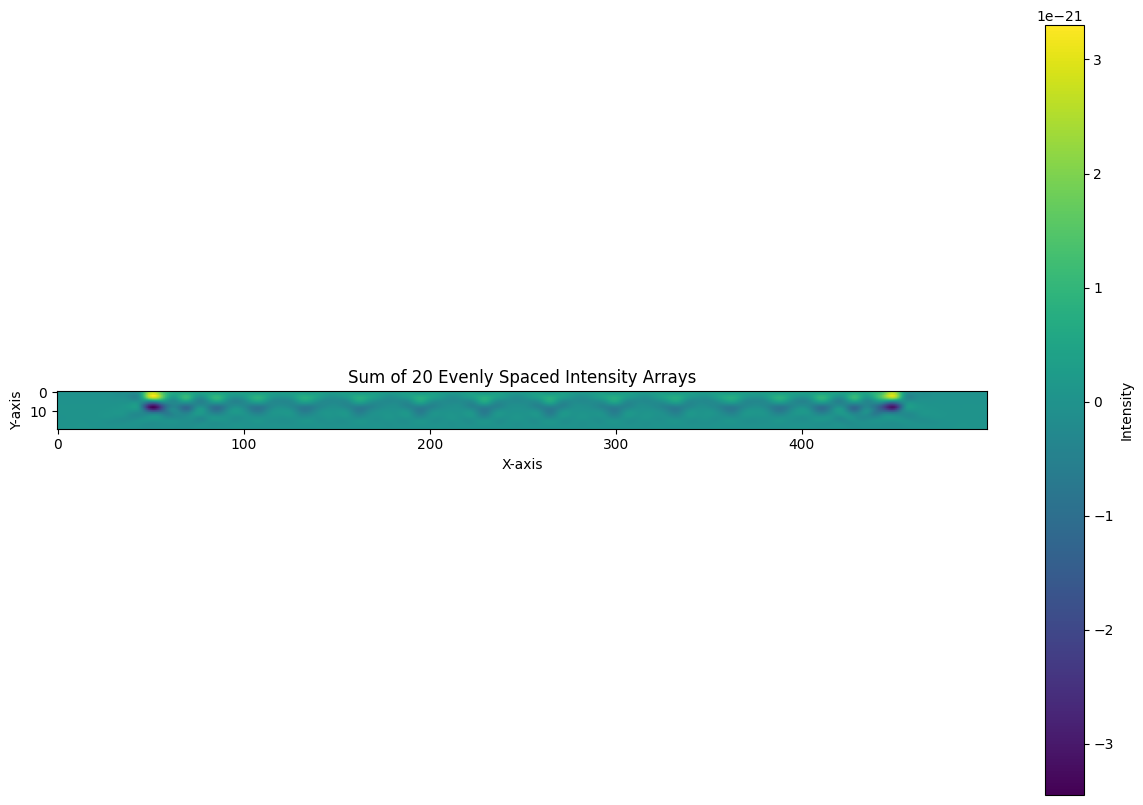

In [94]:
sum_and_plot_intensity_arrays(testout2[:,1], 20, fig_size=(15,10))